In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use("ggplot")
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import nltk
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,ConfusionMatrixDisplay

In [2]:
df = pd.read_csv("/Users/yusufaksoy/Desktop/sentiment analyze/vaccination_tweets.csv")

In [3]:
df.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11020 entries, 0 to 11019
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                11020 non-null  int64 
 1   user_name         11020 non-null  object
 2   user_location     8750 non-null   object
 3   user_description  10341 non-null  object
 4   user_created      11020 non-null  object
 5   user_followers    11020 non-null  int64 
 6   user_friends      11020 non-null  int64 
 7   user_favourites   11020 non-null  int64 
 8   user_verified     11020 non-null  bool  
 9   date              11020 non-null  object
 10  text              11020 non-null  object
 11  hashtags          8438 non-null   object
 12  source            11019 non-null  object
 13  retweets          11020 non-null  int64 
 14  favorites         11020 non-null  int64 
 15  is_retweet        11020 non-null  bool  
dtypes: bool(2), int64(6), object(8)
memory usage: 1.2+ MB


In [5]:
df.isnull().sum()

id                     0
user_name              0
user_location       2270
user_description     679
user_created           0
user_followers         0
user_friends           0
user_favourites        0
user_verified          0
date                   0
text                   0
hashtags            2582
source                 1
retweets               0
favorites              0
is_retweet             0
dtype: int64

In [6]:
df.columns

Index(['id', 'user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'hashtags', 'source', 'retweets', 'favorites',
       'is_retweet'],
      dtype='object')

In [7]:
data = df.drop(['id', 'user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'hashtags', 'source', 'retweets', 'favorites',
       'is_retweet'],axis=1)

In [8]:
data.head()

,text
0,Same folks said daikon paste could treat a cyt...
1,While the world has been on the wrong side of ...
2,#coronavirus #SputnikV #AstraZeneca #PfizerBio...
3,"Facts are immutable, Senator, even when you're..."
4,Explain to me again why we need a vaccine @Bor...


In [9]:
print(data["text"].iloc[0],"\n")
print(data["text"].iloc[1],"\n")
print(data["text"].iloc[2],"\n")
print(data["text"].iloc[3],"\n")



Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF 

While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlCHrZjkhm 

#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P 

Facts are immutable, Senator, even when you're not ethically sturdy enough to acknowledge them. (1) You were born i… https://t.co/jqgV18kch4 



In [10]:
from nltk.tokenize import wordpunct_tokenize

In [45]:
def data_processing(text):
    text = text.lower()
    text = re.sub("https\S+|www\S+https\S+", '',str(text), flags=re.MULTILINE)
    text = re.sub('\@w+|\#','',str(text))
    text = re.sub('[^\w\s]','',str(text))
    text = re.sub('_','',str(text))
    
    text_tokens = wordpunct_tokenize(str(text))
    filtered_text = [w for w in text_tokens if not w in stop_words]
    return " ".join(filtered_text)
    

In [46]:
data.text = data['text'].apply(data_processing)

In [47]:
data  = data.drop_duplicates("text")

In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10463 entries, 0 to 11018
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   text       10463 non-null  object 
 1   polarity   10463 non-null  float64
 2   sentiment  10463 non-null  object 
dtypes: float64(1), object(2)
memory usage: 327.0+ KB


In [49]:
data.head()

,text,polarity,sentiment
0,folks said daikon paste could treat cytokine s...,0.0,Natural
1,world wrong side history year hopefully bigges...,-0.5,Negative
2,coronavirus sputnikv astrazeneca pfizerbiontec...,0.0,Natural
3,facts immutable senator even youre ethically s...,0.1,Positive
4,explain need vaccine borisjohnson matthancock ...,0.0,Natural


In [50]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
data['text'] = data['text'].apply(lambda x: cleaning_numbers(x))


In [51]:
print(data.text.iloc[2])

coronavirus sputnikv astrazeneca pfizerbiontech moderna covid russian vaccine created last years


## kelimeleri stem işleminden geçirerek aslında aynı kelimelerin köklerinden yeni kelime oluşmasını engelliyoruz.

In [52]:
stemmer = PorterStemmer()
def stemming(data):
    text = [stemmer.stem(word) for word in data]
    return data

In [53]:
data["text"] = data["text"].apply(lambda x: stemming(x))

In [54]:
data.head()

,text,polarity,sentiment
0,folks said daikon paste could treat cytokine s...,0.0,Natural
1,world wrong side history year hopefully bigges...,-0.5,Negative
2,coronavirus sputnikv astrazeneca pfizerbiontec...,0.0,Natural
3,facts immutable senator even youre ethically s...,0.1,Positive
4,explain need vaccine borisjohnson matthancock ...,0.0,Natural


In [55]:
print(data["text"].iloc[0],"\n")
print(data["text"].iloc[1],"\n")
print(data["text"].iloc[2],"\n")
print(data["text"].iloc[3],"\n")
print(data["text"].iloc[4],"\n")


folks said daikon paste could treat cytokine storm pfizerbiontech 

world wrong side history year hopefully biggest vaccination effort weve ev 

coronavirus sputnikv astrazeneca pfizerbiontech moderna covid russian vaccine created last years 

facts immutable senator even youre ethically sturdy enough acknowledge born 

explain need vaccine borisjohnson matthancock whereareallthesickpeople pfizerbiontech 



In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10463 entries, 0 to 11018
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   text       10463 non-null  object 
 1   polarity   10463 non-null  float64
 2   sentiment  10463 non-null  object 
dtypes: float64(1), object(2)
memory usage: 327.0+ KB


In [57]:
def polarity(text):
    return TextBlob(text).sentiment.polarity

In [58]:
data["polarity"] = data["text"].apply(polarity)

In [59]:
data.head(15)

,text,polarity,sentiment
0,folks said daikon paste could treat cytokine s...,0.000000,Natural
1,world wrong side history year hopefully bigges...,-0.500000,Negative
2,coronavirus sputnikv astrazeneca pfizerbiontec...,0.000000,Natural
3,facts immutable senator even youre ethically s...,0.100000,Positive
4,explain need vaccine borisjohnson matthancock ...,0.000000,Natural
5,anyone useful adviceguidance whether covid vac...,0.400000,Positive
6,bit sad claim fame success vaccination patriot...,-0.100000,Negative
7,many bright days best bidenharris winning elec...,0.675000,Positive
8,covid vaccine getting covidvaccine covid pfize...,0.000000,Natural
9,covidvaccine states start getting covidvaccine...,0.000000,Natural


In [60]:
def sentiment_check(label):
    if label < 0:
        return "Negative"
    elif label == 0 :
        return  "Natural"
    elif label >0:
        return "Positive"

In [61]:
data["sentiment"] = data["polarity"].apply(sentiment_check)

In [62]:
data.head(50)

,text,polarity,sentiment
0,folks said daikon paste could treat cytokine s...,0.000000,Natural
1,world wrong side history year hopefully bigges...,-0.500000,Negative
2,coronavirus sputnikv astrazeneca pfizerbiontec...,0.000000,Natural
3,facts immutable senator even youre ethically s...,0.100000,Positive
4,explain need vaccine borisjohnson matthancock ...,0.000000,Natural
5,anyone useful adviceguidance whether covid vac...,0.400000,Positive
6,bit sad claim fame success vaccination patriot...,-0.100000,Negative
7,many bright days best bidenharris winning elec...,0.675000,Positive
8,covid vaccine getting covidvaccine covid pfize...,0.000000,Natural
9,covidvaccine states start getting covidvaccine...,0.000000,Natural


<AxesSubplot: xlabel='sentiment', ylabel='count'>

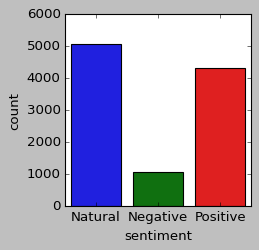

In [63]:
fig = plt.figure(figsize=(3,3))
sns.countplot(x="sentiment",data=data)

In [64]:
vec = CountVectorizer(ngram_range=(1,2)).fit(data["text"])
#It is used to transform a given text into a vector on the basis of the frequency (count) of each word that occurs in the entire text.

In [65]:
feature_names = vec.get_feature_names()
print("Number of features: {}\n".format(len(feature_names)))
print("First 20 Features: {}\n".format((feature_names[:20])))


Number of features: 74937

First 20 Features: ['aacommunities', 'aafp', 'aafp aacommunities', 'aagain', 'aagain way', 'aampa', 'aampa plead', 'aampe', 'aampe nurse', 'aap', 'aap first', 'aapsonline', 'aapsonline states', 'aaro', 'aaron', 'aaron siri', 'aartipole', 'aartipole talks', 'aatmanirbharbharat', 'aatmanirbharbharat wud']



In [66]:
X = data["text"]
y= data["sentiment"]
x = vec.transform(X)

In [67]:
x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=42,test_size=0.2)

In [68]:
import warnings
warnings.filterwarnings("ignore")

In [69]:
logreg = LogisticRegression()
logreg.fit(x_train,y_train)
logreg_pred = logreg.predict(x_test)
logreg_acc = accuracy_score(logreg_pred,y_test)
print("Test Accuracy: {:.2f}%".format(logreg_acc*100))

Test Accuracy: 85.43%


In [70]:
print(confusion_matrix(y_test,logreg_pred))
print("\n")
print(classification_report(y_test,logreg_pred))

#recall: positive predictive value 
#f1-score: The combines the precision and recall of a classifier into a single metric by taking their harmonic mean. 
#recall : number of correct results divided by the number of results that should have been returned.



[[1017    3   10]
 [ 114   56   43]
 [ 129    6  715]]


              precision    recall  f1-score   support

     Natural       0.81      0.99      0.89      1030
    Negative       0.86      0.26      0.40       213
    Positive       0.93      0.84      0.88       850

    accuracy                           0.85      2093
   macro avg       0.87      0.70      0.72      2093
weighted avg       0.86      0.85      0.84      2093



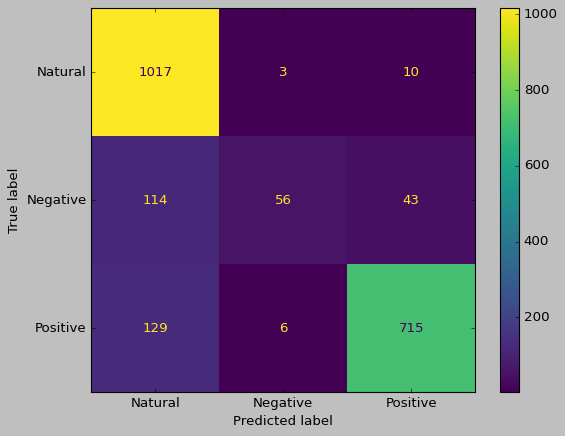

In [71]:
style.use("classic")
cm = confusion_matrix(y_test,logreg_pred,labels=logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=logreg.classes_)
disp.plot()                      

In [72]:
from sklearn.model_selection import GridSearchCV

In [73]:
param_grid = {"C":[0.001,0.01,0.1,1,10]}
grid = GridSearchCV(LogisticRegression(),param_grid)
grid.fit(x_train,y_train)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]})

In [74]:
print("Best parameters:",grid.best_params_)

Best parameters: {'C': 10}


In [75]:
y_pred = grid.predict(x_test)

In [76]:
logreg_acc = accuracy_score(y_pred,y_test)
print("Accuracy Score: {:.2f}".format(logreg_acc*100))

Accuracy Score: 86.62
